<a href="https://colab.research.google.com/github/FreddyMLS/Diplom/blob/(v-2.1)%D0%94%D0%AD-%D0%B4%D0%BB%D1%8F-%D1%81%D0%BC%D0%B5%D1%89%D0%B5%D0%BD%D0%B8%D1%8F/v_2_1_%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC(%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C%7B%D1%87%D0%B8%D1%81%D0%BB%D0%BE%7D)_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import random

# my_list = [random.random() for _ in range(2499)]

In [3]:
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import pandas as pd

from keras.utils import to_categorical

import numpy as np

from sklearn.metrics import classification_report

import random
from deap import base, creator, tools, algorithms
from deap import algorithms

In [4]:
#Подключение к Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Архитектура нейронной сети

In [5]:
def model_neuron(input_dim, num_classes):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_dim=input_dim, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
  ])
  return model

#Функции

##Вспомогательные функции

In [6]:
# Построение графиков прогресса обучения
def charts(history,epochs):
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.grid()

  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.grid()
  plt.show()

In [7]:
#Перевод y в формат [0,1,2,3, ...]
def str_in_int(x):
  labels = x
  label_to_id = {label: idx for idx, label in enumerate(set(labels))}
  vector = [label_to_id[label] for label in labels]
  return vector

In [8]:
#График мощности классов
def class_power_graph(y_data):
  y_df = str_in_int(y_data)
  counts = np.array(np.bincount(y_df))
  #График
  index = np.linspace(0, (len(set(y_data)))-1, (len(set(y_data))), dtype=int)
  index = index.astype(str)
 
  fig, ax = plt.subplots()
  ax.bar(index,counts)

  for i, v in enumerate(counts):
      ax.text(i, v+1, str(v), ha='center', va='bottom')

  plt.title('Мощность классов')
  plt.xlabel('Класс')
  plt.ylabel('Количесвто')
  plt.show()

##ДЭ

In [9]:
#Получение информации о весах без смещения
def count_weights1(model):
  weights = model.get_weights()
  weights_shape = []
  weights_count = 0

  #Форма весов
  for i in range(0, len(weights), 2):
    n = weights[i].shape
    weights_shape.append(n)
  #Количесвто весов
  for i in range(len(weights_shape)):
    weights_count += np.prod(weights_shape[i])

  return weights_count, weights_shape

In [10]:
#Получение информации о весах со смещения
def count_weights(model):
  weights = model.get_weights()
  weights_shape = []
  weights_count = 0

  #Форма весов
  for i in range(0, len(weights)):
    n = weights[i].shape
    weights_shape.append(n)
  #Количесвто весов
  for i in range(len(weights_shape)):
    weights_count += np.prod(weights_shape[i])

  return weights_count, weights_shape

In [11]:
#Создание листа новых весов нужной формы без учета смещения
def new_weights1(individual,weights_shape,model):
  weights = model.get_weights()
  new_weights = []

  #Разделение новых весов на массивы слоев
  first_layer = np.array(individual[0: (np.prod(weights_shape[0]))])
  second_layer = np.array(individual[(np.prod(weights_shape[0])): (np.prod(weights_shape[1])+np.prod(weights_shape[0]))])
  third_layer = np.array(individual[(np.prod(weights_shape[1])+np.prod(weights_shape[0])): len(individual)])

  #лист новых весов нужной формы
  for i in range(0, len(weights)):
      n = weights[i].shape
      if i == 0:
        fl = first_layer.reshape(n)
        new_weights.append(fl)
      elif (i == 2): 
        sl = second_layer.reshape(n)
        new_weights.append(sl)
      elif (i == 4):
        tl = third_layer.reshape(n)
        new_weights.append(tl)
      else:
        new_weights.append(weights[i])
  return new_weights

In [12]:
#Создание листа новых весов нужной формы с учетом смещения
def new_weights(individual,weights_shape,model):
  weights = model.get_weights()
  new_weights = []
  down_range = 0
  hight_range = 0
  for i in range(0, len(weights)):
    hight_range = (np.prod(weights_shape[i]))+down_range

    i_leyer = np.array(individual[down_range: hight_range])

    i_leyer_reshape = i_leyer.reshape(weights[i].shape)
    new_weights.append(i_leyer_reshape)

    down_range = hight_range
  return new_weights

#Ирисы

##Подготовка данных

In [13]:
import time
start_time_iris = time.time()

In [14]:
# Загрузка данных
iris = load_iris()
x = iris.data
y = iris.target

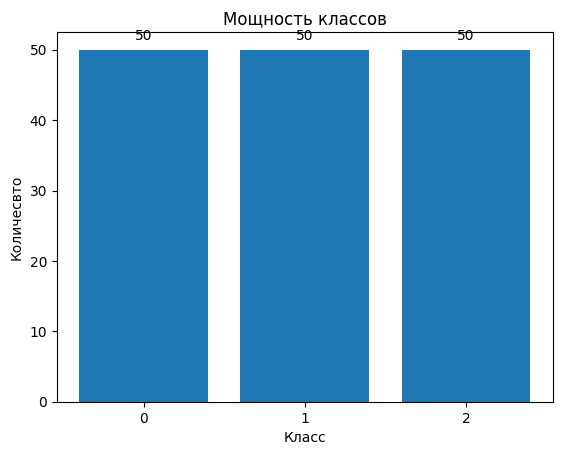

In [15]:
#График мощности классов
class_power_graph(y)

In [16]:
#Кореляция данных к классам
y1 = pd.DataFrame(y, columns =["4"])
x1 = pd.DataFrame(x)
df_iris = pd.concat([x1, y1], axis=1)

correlations = df_iris.corr()['4'].drop('4')
display(correlations)

0    0.782561
1   -0.426658
2    0.949035
3    0.956547
Name: 4, dtype: float64

In [17]:
# Разделение данных на обучающую и тестовую выборки
x_train, x_test, y_train_iris, y_test_iris = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

In [18]:
# Стандартизация данных
scaler = StandardScaler()
x_train_iris = scaler.fit_transform(x_train)
x_test_iris = scaler.transform(x_test)

In [19]:
#Количество признаков
input_dim_iris = x_train_iris.shape[1]

In [20]:
#Количество классов
num_classes_iris = len(set(y_train_iris))

In [21]:
#Перевод классов в формат one-hot encoding
vector_y_train_iris = to_categorical(y_train_iris, num_classes_iris)
vector_y_test_iris = to_categorical(y_test_iris, num_classes_iris)

##ДЭ

In [22]:
#создание модели
model_iris=model_neuron(input_dim_iris,num_classes_iris)

In [23]:
#Информация о весах
weights_count_iris,weights_shape_iris = count_weights(model_iris)

In [24]:
# функция для оценки качества модели
def evaluate1(individual):
    # установка весов нейронной сети
    model_iris.set_weights(new_weights(individual,weights_shape_iris,model_iris))
    # компиляция модели
    model_iris.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # оценка качества модели
    loss, acc = model_iris.evaluate(x_train_iris, vector_y_train_iris, verbose=0)
    return acc,

# определение типов индивидуумов и популяции
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# генерация случайных весов нейронной сети
toolbox.register('attr_weight', lambda: random.uniform(-1, 1))
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_weight, n=(weights_count_iris))
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

# регистрация функций для операторов дифференциальной эволюции
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('evaluate', evaluate1)

# Создаем объект hall of fame для сохранения лучшего индивидуума
hof_iris = tools.HallOfFame(maxsize=1)

# запуск дифференциальной эволюции
pop = toolbox.population(n=25)
best_ind, best_fit = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=25,halloffame=hof_iris, verbose=False)


In [25]:
#лучшие веса нейронной сети
print(f"Best individual: {hof_iris[0]}, Fitness: {hof_iris[0].fitness.values[0]}")

Best individual: [-0.969810231679894, 0.7470331294669814, -0.654888879826123, 0.5834991551793511, -0.026977883636233102, -0.3493040063151951, 0.6556776581173618, -0.03943626230490349, 0.29706962226642514, -0.04449729941259917, 0.8623340654874141, -0.03514281902333938, 0.18912517799200068, 0.3886639067835931, 0.8318305953828729, -0.08340622911288657, 0.8366382849650353, -0.5540656782941495, 1.0754646331471829, 0.15866723885376222, 0.008323009106818269, 0.9333183438646941, 0.5083039804878373, 0.7318018896481857, -0.09310384132889094, 0.44303191086358606, 0.8811783512549729, -0.8144073731655281, -0.900928762936382, -0.22103943039681265, 0.21073599845167962, 0.7686613816831485, -1.163025723028755, 0.3117620574688861, -0.39437662667884, 0.8754126952063366, 0.7509856554318188, -0.3877150219191543, -0.6223074415015847, 0.8966043512883031, -0.5210390126573157, -1.1186721934501593, 0.38314458201049684, 0.12368513870390774, -0.3580539242087768, 0.09622609269683813, 0.1432156376914926, 1.14243732

In [26]:
# установка весов нейронной сети с лучшими значениями
model_iris.set_weights(new_weights(hof_iris[0],weights_shape_iris,model_iris))

##Обучение и оценка качества нейронной сети

In [27]:
#Компиляция модели
model_iris.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
# Обучение модели
epochs = 100
history = model_iris.fit(x_train_iris, vector_y_train_iris,validation_data=(x_test_iris, vector_y_test_iris), epochs=epochs, batch_size=9, verbose=0)

In [29]:
# Оценка качества модели на тестовой выборке
loss, accuracy = model_iris.evaluate(x_test_iris, vector_y_test_iris, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 100.00


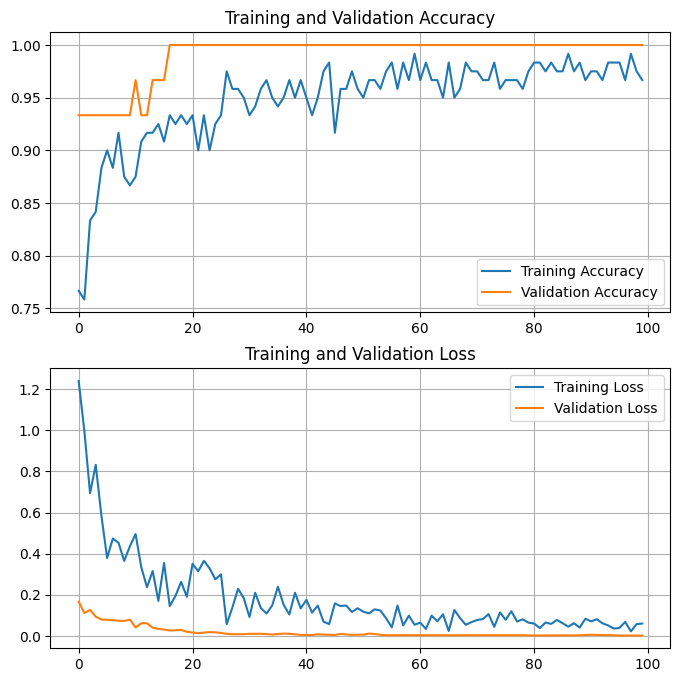

In [30]:
#Построение графиков обучения модели
charts(history,epochs)

In [31]:
#Предсказание модели
y_pred_iris = model_iris.predict(x_test_iris)
y_pred_classes_iris = np.argmax(y_pred_iris, axis=1)
y_test_classes_iris = np.argmax(vector_y_test_iris, axis=1)

1/1 [==============================] - 0s 165ms/step


In [32]:
#вывод classification_report
print(classification_report(y_test_classes_iris, y_pred_classes_iris))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [33]:
#Время выполнения блока
end_time_iris = time.time()
min_iris = (end_time_iris - start_time_iris) // 60
sec_iris = (end_time_iris - start_time_iris) % 60
print("Время выполнения: ",min_iris," минут, ",sec_iris," секунд")

Время выполнения:  2.0  минут,  40.638421297073364  секунд


#Вино

##Подготовка данных

In [61]:
import time
start_time_wine = time.time()

In [62]:
#Загрузка данных
df = pd.read_csv("/content/drive/MyDrive/winequality-red.csv")
display(df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [63]:
x_data = df.drop('quality', axis=1)
y_data = df['quality']

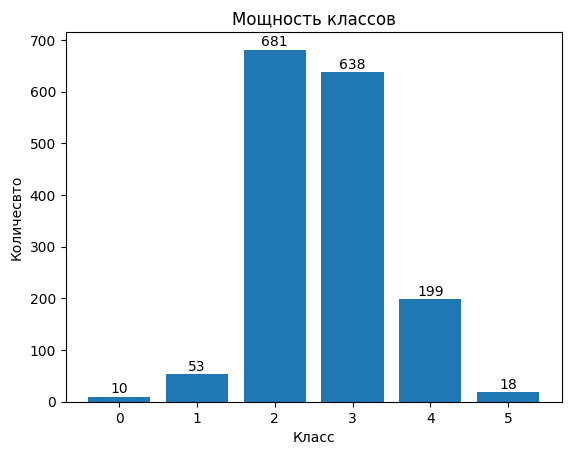

In [64]:
#График мощности классов
class_power_graph(y_data)

In [65]:
#Корреляция признаков к классам
correlations = df.corr()['quality'].drop('quality')
display(correlations)
print("===========================")
display((abs(correlations) > 0.1) == True)

fixed acidity           0.124052
volatile acidity       -0.390558
citric acid             0.226373
residual sugar          0.013732
chlorides              -0.128907
free sulfur dioxide    -0.050656
total sulfur dioxide   -0.185100
density                -0.174919
pH                     -0.057731
sulphates               0.251397
alcohol                 0.476166
Name: quality, dtype: float64

fixed acidity            True
volatile acidity         True
citric acid              True
residual sugar          False
chlorides                True
free sulfur dioxide     False
total sulfur dioxide     True
density                  True
pH                      False
sulphates                True
alcohol                  True
Name: quality, dtype: bool

In [66]:
#Удаление признаков с плохой корреляцией
x_data_cor= x_data.transpose()
x_data_cor = np.array(x_data_cor)
x_data_cor = x_data_cor[(abs(correlations) > 0.1) == True] #Условие
x_data_cor = x_data_cor.transpose()

In [67]:
# Разделение данных на обучающую и тестовую выборки
x_train_wine, x_test_wine, y_train_wine, y_test_wine = train_test_split(x_data, y_data, test_size=0.2, random_state=32)

In [68]:
#Стандартизация данных
scaler = StandardScaler()
x_train_wine = scaler.fit_transform(x_train_wine)
x_test_wine = scaler.transform(x_test_wine)

In [69]:
#Количество признаков
input_dim_wine = x_train_wine.shape[1]

In [70]:
#Количестов классов
num_classes_wine = len(set(y_train_wine))

In [71]:
#Перевод классов в формат от 0 до (количество классов)
y_train_wine = np.array(str_in_int(y_train_wine))
y_test_wine = np.array(str_in_int(y_test_wine))

In [72]:
#Перевод классов в формат one-hot encoding
vector_y_train_wine = to_categorical(y_train_wine, num_classes_wine)
vector_y_test_wine = to_categorical(y_test_wine, num_classes_wine)

##ДЭ

In [73]:
#создание модели
model_wine=model_neuron(input_dim_wine,num_classes_wine)

In [74]:
#Информация о весах
weights_count_wine,weights_shape_wine = count_weights(model_wine)

In [75]:
# функция для оценки качества модели
def evaluate(individual):
    # установка весов нейронной сети
    model_wine.set_weights(new_weights(individual,weights_shape_wine,model_wine))
    # компиляция модели
    model_wine.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # оценка качества модели
    loss, acc = model_wine.evaluate(x_train_wine, vector_y_train_wine, verbose=0)
    return acc,

# определение типов индивидуумов и популяции
creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# генерация случайных весов нейронной сети
toolbox.register('attr_weight', lambda: random.uniform(-1, 1))
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.attr_weight, n=(weights_count_wine))
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

# регистрация функций для операторов дифференциальной эволюции
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutGaussian, mu=0, sigma=0.2, indpb=0.1)
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('evaluate', evaluate)

# Создаем объект hall of fame для сохранения лучшего индивидуума
hof_wine = tools.HallOfFame(maxsize=1)

# запуск дифференциальной эволюции
pop = toolbox.population(n=25)
best_ind, best_fit = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=25,halloffame=hof_wine, verbose=False)


/usr/local/lib/python3.10/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [76]:
#лучшие веса нейронной сети
print(f"Best individual: {hof_wine[0]}, Fitness: {hof_wine[0].fitness.values[0]}")

Best individual: [0.2464470078895824, 0.027300500302139263, 0.623450650055017, 0.4710681139124816, -0.19640735809482568, 0.37093145904292024, -0.5912734527505137, 0.14728310189713456, -0.3455704239950088, -0.38903376057495936, -1.3188452555598649, 0.8690005528427724, -0.2100648124678972, -0.5373445625043589, 0.021639119549740307, 0.31567934637685746, 0.09548778241765987, -0.4977618441192717, 0.7505914938913567, 0.9029814586603988, 0.7468667306439476, -0.23779635638216678, -0.4094147050219903, 0.5513717318684486, -0.7520486913257571, -0.7388035919446998, -0.5629452086080191, -0.976532091259783, 0.29144602835963584, -0.5127463812018385, -0.47991471410882847, 0.1393707510700248, -0.6681228726455429, 0.22353305074972818, 0.8533580776155048, 0.7405991273806332, -0.5741940435643675, 0.28131583273495786, -0.14428487464756445, -0.06092338954083476, -0.3032873838132255, -0.394142291977089, -0.1196057947083834, -0.10693261162774487, 0.5058049742933766, -0.4492435637990481, -0.2874998359534964, -

In [77]:
# установка весов нейронной сети с лучшими значениями
model_wine.set_weights(new_weights(hof_wine[0],weights_shape_wine,model_wine))

##Обучение и оценка качества нейронной сети

In [78]:
#Компиляция модели
model_wine.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [79]:
#Обучение модели
epochs_wine = 200
history = model_wine.fit(x_train_wine, vector_y_train_wine,validation_data=(x_test_wine, vector_y_test_wine), epochs=epochs_wine, batch_size= 9, verbose=0)

In [80]:
# Оценка качества модели на тестовой выборке
loss, accuracy = model_wine.evaluate(x_test_wine, vector_y_test_wine, verbose=0)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 60.00


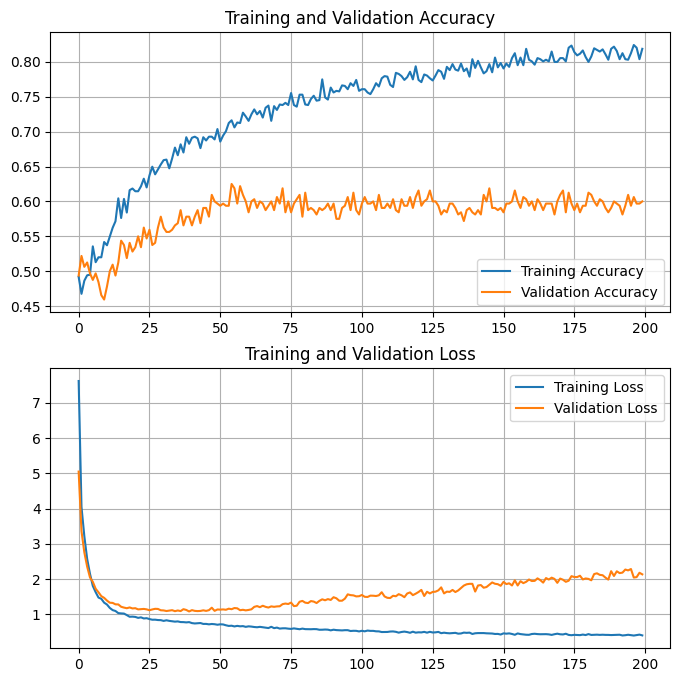

In [81]:
#Построение графиков
charts(history,epochs_wine)

In [82]:
#Предсказание модели
y_pred_wine = model_wine.predict(x_test_wine)
y_pred_classes_wine = np.argmax(y_pred_wine, axis=1)
y_test_classes_wine = np.argmax(vector_y_test_wine, axis=1)

10/10 [==============================] - 0s 2ms/step


In [83]:
#вывод classification_report
print(classification_report(y_test_classes_wine, y_pred_classes_wine))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         8
           2       0.63      0.73      0.68       120
           3       0.61      0.62      0.61       146
           4       0.52      0.33      0.40        40
           5       0.00      0.00      0.00         5

    accuracy                           0.60       320
   macro avg       0.29      0.28      0.28       320
weighted avg       0.58      0.60      0.58       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
#Время выполнения блока
end_time_wine = time.time()
min_wine = (end_time_wine - start_time_wine) // 60
sec_wine = (end_time_wine - start_time_wine) % 60
print("Время выполнения: ",min_wine," минут, ",sec_wine," секунд")

Время выполнения:  3.0  минут,  49.51532030105591  секунд
